# Project Description

*The objective of this project is to create a set of relatively lightweight neural networks that will be capable of quickly estimating the flammability parameters for a complex gas mixture. As inputs, the network(s) will take:*

>* The mole (volume) fraction of the constituent gases in the mixture
>* The temperature of the gas mixture
>* The pressure of the gas mixture

*With these inputs, the network(s) will estimate the following flammability parameters:*

>* The Lower Flammable Limit (LFL)
>* The Upper Flammable Limit (UFL)
>* The laminar flame speed ($S_{u}$)
>* The adiabatic pressure ($P_{max}$) [Optional Later]
>* The adiabatic tempreature ($T_{ad}$) [Optional Later]

*These parameters are important in determining the risk of fire and explosion in a variety of settings. While the flammability parameters of pure gases are tabulated and known, the values for mixtures can vary substantially. There exists several methods for determining these values for a mixture. However, these methods are all highly iterative and require reasonably sophisticated thermodynamics information.*



## Theoretical Background

### <u>Flammability Limits</u>

*When a flammable gas is mixed with oxygen, it has the potential to burn. However, if the concentration of flammable gas is too low, it will not be able to burn. In essence, below a certain threshold there are not enough fuel molecules near each other to propagate the combustion reaction forward. Similarly, if the concentration is too high, there aren't enough oxygen molecules in proximity to each fuel molecule to allow the reaction to self propagate.*

*We call these limits the Lower Flammmability Limit (LF) and Upper Flammability (UFL). These limits have many implications and applications in combustion. In particular, they are critical to preventing fires and explosions by understanding when a hazard exists.*

*Unfortunately, there is not an analytical closed form solution to determine either of these limits. Several methods do exist to estimate these values, but all have their limitations in terms of accuracy and under what conditions. The primary two methods are:

1. Le Chatelier's Method
2. Critical Adiabatic Flame Temperature (CAFT) Method

*Several additional methods exist which are in essence modifications of these two methods to account for different conditions or to improve accuracy.*

### <u> Flame Speed </u>

*A critical parameter in many flammability analysis cases is the "Laminar Flame Speed" of a fuel. This is essentially the rate at which the flame front moves through a stationary gas front the point of initial ignition.*

*In cases of explosion it has significant influence on the overpressure experienced by nearby structures and therefore the damage experienced.*



## Project Process Outline

* A tenative plan of attack for getting started on the project is outlined below.*

### Simplified Model

1. **[Done] Generate (Simplified) Synthetic Data Set**

 *There doesn't exist a sufficiently granular and complete set of experimental flammability data for gas mixtures to form a training set. Instead, we will define a randomly distributed sample grid and then use the existing iterative method to determine the "true" values.*

 *We do have a (small) set of existing data for battery gas mixtures. However, it covers a small subset of the possible input space and training on only it would likely not produce a generalized model applicable to other mixtures.*


2. **[Done] Apply Existing Methods to (Simplified) Synthetic Data Set**

 *Take the synthetic set of mixtures generated above and run it through the existing methods to create a complete training set for LFL, UFL, and Su.*

3. **[To Do] Train Simplified Model**

  *The full set of desired input features for the model(s) is relatively complex. For this reason, we will first train a simplified model with a small input feature set to validate the general feasiblity of our approach. We will negelect the higher hydrocarbons and diluent gases.*

  <u>Gas Species</u>:  
  >*Carbon Dioxide ($CO_{2}$), <br>
  >Carbon Monoxide ($CO$), <br>
  >Hydrogen ($H_{2}$), <br>
  >Methane ($CH_{4}$), <br>
  >Ethylene ($C_{2}H_{4}$), <br>
  >Ethane ($C_{2}H_{6}$), <br>
  >Propylene ($C_{3}H_{6}$), --> Not in Cantera <br>
  >Propane ($C_{3}H_{8}$)*

4. **[To Do] Hyper-Parameter Search and Sensitivity Analysis**

  *The network being developed here is complex enough that we should use some of the methods discussed in class to tune the hyper-parameters used. In particular, the depth of the network and the number of neurons.*

  *Right now, I have no idea where to start with these parameter selections.*


# Project Code


## Import Section


In [1]:
!pip install cantera --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 37.6 MB/s eta 0:00:00


In [2]:
###LIBRARY AND PACKAGE IMPORT STATEMENTS###

# Basic Libraries
import numpy as np
import pandas as pd
import random

# Scientific Libraries
import cantera as ct

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

#Ploting and Graphics
import matplotlib.pyplot as plt

# Utility Packages
from tqdm.notebook import tqdm
from datetime import datetime       # Import the datetime library for timestamping data
import uuid
import collections
from collections import defaultdict # Specifically import the defaultdict function

# File management
# from google.colab import drive, files


## Parameter Definitions

In [3]:
## DEFINE CONSTITUENT SPECIES ##

# File directory stuff
data_folder = 'Data_Files'

# Define the names of the gas species
gas_species = ["CO2",
               "CO",
               "H2",
               "CH4",
               "C2H4",
               "C2H6",
               "C3H8",
                ]

fuel_species = ["CO",
                "H2",
                "CH4",
                "C2H4",
                "C2H6",
                "C3H8",
                ]

inert_species = ['N2',
                 'CO2',
                 #'Ar',
                 ]


# Useful dictionaries for shifting back and forth between written names and formulas
name_formula_all = {'Carbon Dioxide': 'CO2',
                    'Carbon Monoxide': 'CO',
                    'Hydrogen': 'H2',
                    'Methane': 'CH4',
                    'Ethylene': 'C2H4',
                    'Ethane': 'C2H6',
                    'Propylene': 'C3H6',   #NOT IN GRIMECH3.0
                    'Propane': 'C3H8'}

formula_name_all = {'CO2': 'Carbon Dioxide',
                    'CO': 'Carbon Monoxide',
                    'H2': 'Hydrogen',
                    'CH4': 'Methane',
                    'C2H4': 'Ethylene',
                    'C2H6': 'Ethane',
                    'C3H6': 'Propylene',    #NOT IN GRIMECH3.0
                    'C3H8': 'Propane',
                    }


## Function Definitions

In [4]:
def data_gen_v1(num):
  # Define the number of mixtures you want in the training set
  # num_mixtures = 5000

  # Initialize an empty list to store the mixtures
  mixtures = []

  # Seed the random number generation so that I will consistently get the same random set for testing
  np.random.seed(1234)
  random.seed(1234)

  # Generate random mixtures
  for _ in range(num_mixtures):

      # Generate random fractions for each gas species
      fractions = [random.uniform(0, 1) for _ in range(len(fuel_species))]

      # Normalize the fractions so they sum up to 1
      total_fraction = sum(fractions)
      fractions = [frac / total_fraction for frac in fractions]

      # Create a dictionary to represent the mixture
      # mixture = {gas_species[i]: fractions[i] for i in range(len(gas_species))}

      # Append the mixture to the list
      mixtures.append(fractions)

  # # Print the generated mixtures
  # for i, mixture in enumerate(mixtures, 1):
  #     print(f"Mixture {i}: {mixture}")

  mixData = np.array(mixtures)                            # Convert the generated list of lists to a numpy array
  DFmixData = pd.DataFrame(mixData, columns=fuel_species)  # Create Pandas DataFrame for easy viewing

  return DFmixData

##############################################################################
##############################################################################

def data_gen_v2(species, num, rand=False):

  '''
  This function is designed to take a set of constituent species and generate a set
  of random mixtures of those species. This is intended to serve as a synthetic data
  set for machine learning training purposes.

  Arguments:
    species -->  [list] containing the chemical formulas (i.e. "CH4") for the fuel species
                  to include in the mixture
    num ------>  [int] representing the number of random mixtures that you want to generate
    rand ----->  [bool] indicating whether the function should truly randomize (True) or use a
                 standard seed for repeatability (False)

  Return:
    mixtures -->  [list of dicts] containing the randomly generated mixtures as rows

  ---------------------------------------
  Earlier versions of this function generated mixtures with all the fuel species. Unfortunately,
  this resulted in datasets that were too uniform. In reality, mixtures could have only a subset
  of two or three constituent species. This version was written to try and compensate for this.

  Subsample Loop:
  1. Randomly chose a number of species to select
  2. Randomly select that many species from the overall species argument
  3. For each of the selected species, randomly generate a value between 0 and 1
  4. Normalize the values to ensure they add to one
  5. Create dictionary for overall species argument list filled with zero values
  6. Assign values to the sub-selected species
  7. Repeat for 'num' times
  '''

  # Define useful stuff
  species_count = len(species)
  mixtures = [] # Intialize empty array to hold the mixtures as they are generated

  # Determine if randomization should be seeded
  if not rand:
  # Seed the random number generation so that I will consistently get the same random set for testing
    np.random.seed(1234)
    random.seed(1234)

  # Testing iteration loop
  for i in tqdm(range(num)):
    sub_num = random.randint(2, species_count)   # Randomly pick what number of constituents will be used
    # print(sub_num)                               # DIAGNOSTIC PRINTING

    sub_list = random.sample(species, sub_num)   # Randomly choose the particular species that will be used for this mixture
    # print(sub_list)                              # DIAGNOSTIC PRINTING

    mix_dict = {spec: 0 for spec in species}     # Initialize an empty dict with keys for all items in "species"
    # print(mix_dict)                              # DIAGNOSTIC PRINTING

    # Generate values for chosen species and normalize
    sub_values = [random.uniform(0, 1) for _ in range(len(sub_list))] #Generate values between 0 and 1 for the chosen species
    total_fraction = sum(sub_values)    # Find sum of fraction values
    sub_values = [frac/total_fraction for frac in sub_values]   # Normalize the sub_values list so that all items sum to one
    sub_round = [round(x, 4) for x in sub_values]               # Round the values to 4 decimal places

    # Iterate through and assign values for chosen species to overall mixture dict
    for i, spec in enumerate(sub_list):
      mix_dict[spec] = sub_round[i]

    # print(mix_dict)   # DIAGNOSTIC PRINTING

    mixtures.append(mix_dict)

  return mixtures

## Generate Mixtures

*The existing body of experimental data for the flammability parameters of fuel mixtures is limited. Instead, we are synthetically generating a dataset using existing estimation methods. We will then use this synthetic dataset to train the model in the hopes that it will provide faster results, particularly with regard to flamespeed.*

---
<b> Version 1 </b>

*The first version of the code simply generated a random set of values for <u>ALL</u> the potential fuel species. In principle, this should result in some mixtures where the concentration is negligible for some of the fuel species. In practice, it seems that the resulting data is too uniform and doesn't provide enough for mixtures with only a 2 or 3 of the constituent species.*

Changes to Implement

  * *Add explicit generation of subsets with only 2 or 3 of the fuel species.*
  * *Explicitly generate a dataset with the pure species. These effectively act as boundary conditions. Maybe keep this separate from the other data and weight differently in calculating the loss.*

---
<b> Version 2 </b>

*The second version of this code picks a subset of the constituent species for each mixture generated, up to and including all of them. This should result in a much more varied dataset.*


In [5]:
# Generate dataset
mix_list = data_gen_v2(fuel_species, 2000, True)       # Call function to generate random mixtures
mixDF = pd.DataFrame(mix_list)      # Create pandas DataFrame

# Generate a timestamped filename to save the mixtures as a CSV
current = datetime.now()                        # Get the current date and time
cString = current.strftime('%m%d_%H%M%S')       # Generate a string from date and time in format [mmdd_hrminsec]
file_name = f'{len(mixDF)}_Mixtures_' + cString + '.csv'      # Concantenate base name with datetime string
data_folder = 'Data_Files'
mix_directory = f'{data_folder}/{file_name}'    # Create full file path with generated name

mixDF.to_csv(mix_directory, encoding='utf-8')   # Save dataframe to CSV with UTF-8 encoding

  0%|          | 0/2000 [00:00<?, ?it/s]

OSError: ignored

In [ ]:
## COLAB DOWNLOAD CODE ##

'''
This code will download the generated data file from Colab to a local computer. Commented out since it isn't necessary for local use.
'''

# DFmixData.to_csv('Gas_Mixture_Data.csv', index=True)    # Create a CSV file from the dataframe
#                                                     # and save to notebook directory

# files.download('/content/Gas_Mixture_Data.csv')         # Create pop-up to download file to local directory


"\nThis code will download the generated data file from Colab to a local computer. Commented out since it isn't necessary for local use.\n"

## Calculate Flammability

*Rather than over load this notebook with all the iterative code to calculate flammability parameters, I will break it out in a separate notebook where I will also provide better comments and an explanation of its pieces. Furthermore, I will probably end up running that code locally as it runs for several days with 10000 mixtures. The process will be:*

1. Generate mixture fractions
2. Download as CSV
3. Run iterative script as straight up .py file locally for speed.
4. Save results as a csv
5. Reopen in this notebook and continue

<!-- [Iterative Code Notebook](https://colab.research.google.com/drive/1RILMAzAZslYWSL5loMO8wAmK6vgsau3F?usp=sharing) -->

## Import Processed Dataset

*Once fully processed to calculate relevant parameters, the resulting datasets will be uploaded to GitHub to create a stable download source.*

In [6]:
FL_url1 = 'https://raw.githubusercontent.com/smatthews95/FlammableML/main/10000_Samples-2023-11-26.csv'
DFLimitsData =pd.read_csv(FL_url1, index_col=0) # Read in limits only dataset



In [7]:
# Drop empty columns
Y = DFLimitsData.drop(['Xf_LFL', 'Xf_UFL', 'Xf_stoich'], axis=1)

## Preliminary Models

### Model Defintions



In [ ]:
# LFL prediction
class LFLNN(nn.Module):
  def __init__(self):
    super(LFLNN, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(6,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,1)
    )
  def forward(self,X):
    return self.layers(X)

LFLmodel = LFLNN()

In [ ]:
# UFL prediction
class UFLNN(nn.Module):
  def __init__(self):
    super(UFLNN, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(6,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,1)
    )
  def forward(self,X):
    return self.layers(X)

UFLmodel = UFLNN()

In [ ]:
# Model for training on both UFL and LFL. Two final outputs.
class FLNN(nn.Module):
  def __init__(self):
    super(FLNN, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(6,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,2)
    )
  def forward(self,X):
    return self.layers(X)

FLmodel = FLNN()

In [58]:
# Laminar Flame Speed
class SNN(nn.Module):
  def __init__(self):
    super(SNN, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(6,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,1)
    )
  def forward(self,X):
    return self.layers(X)

class SNN4(nn.Module):
  def __init__(self):
    super(SNN4, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(6,40),
        nn.Tanh(),
        nn.Linear(40,40),
        nn.Tanh(),
        nn.Linear(40,40),
        nn.Tanh(),
        nn.Linear(40,40),
        nn.Tanh(),
        nn.Linear(40,40),
        nn.Tanh(),
        nn.Linear(40,40),
        nn.Tanh(),
        nn.Linear(40,40),
        nn.Tanh(),
        nn.Linear(40,40),
        nn.Tanh(),
        nn.Linear(40,40),
        nn.Tanh(),
        nn.Linear(40,1)
    )
  def forward(self,X):
    return self.layers(X)


In [ ]:
Smodel = SNN()

In [9]:
Smodel2 = SNN()

### Model Training

In [10]:
X = Y.copy(deep=True)
#LFL = DFLimitsData['LFL']
#UFL = DFLimitsData['UFL']
#FL = DFLimitsData[['LFL','UFL']]
Su = X[['Su_stoich','LFL','UFL']]

X_train_target, X_val_test_target, Su_train, Su_val_test = train_test_split(X, Su, test_size = 0.2)
X_test_target,X_val_target, Su_test, Su_val = train_test_split(X_val_test_target, Su_val_test, test_size=0.2)

X_train = X_train_target.drop(['Su_stoich','LFL', 'UFL'], axis=1)
X_test = X_test_target.drop(['Su_stoich','LFL', 'UFL'], axis=1)
X_val = X_val_target.drop(['Su_stoich','LFL', 'UFL'], axis=1)

training process for LFL prediction:   0%|          | 0/60000 [00:00<?, ?it/s]

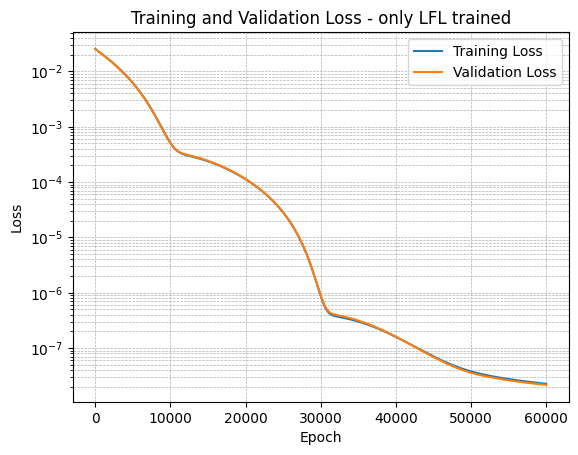

In [ ]:
# Code for training only LFL value
X_train_tensorLFL = torch.from_numpy(X_train.values.astype(np.float32))
LFL_train_tensor = torch.from_numpy(Su_train['LFL'].values.astype(np.float32)).view(-1,1)

X_test_tensorLFL = torch.from_numpy(X_test.values.astype(np.float32))
LFL_test_tensor = torch.from_numpy(Su_test['LFL'].values.astype(np.float32)).view(-1, 1)

X_val_tensorLFL = torch.from_numpy(X_val.values.astype(np.float32))
LFL_val_tensor = torch.from_numpy(Su_val['LFL'].values.astype(np.float32)).view(-1, 1)

optimizer = optim.Adam(LFLmodel.parameters(), lr=0.000001)
loss_fn = nn.MSELoss()

LFL_losses = []
LFL_val_losses = []

for epoch in tqdm(range(60000), desc = 'training process for LFL prediction'):
  #Training
  LFL_pred = LFLmodel(X_train_tensorLFL)
  loss = loss_fn(LFL_pred, LFL_train_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  LFL_losses.append(loss.item())

  # Validation
  LFLmodel.eval()  # Set the model to evaluation mode
  with torch.no_grad():  # No need to track the gradients
      LFL_val_pred = LFLmodel(X_val_tensorLFL)
      LFLval_loss = loss_fn(LFL_val_pred, LFL_val_tensor)
      LFL_val_losses.append(LFLval_loss.item())


# Plotting both training and validation losses
plt.figure()
plt.semilogy(LFL_losses, label='Training Loss')
plt.semilogy(LFL_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.title('Training and Validation Loss - only LFL trained')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


training process for UFL prediction:   0%|          | 0/300000 [00:00<?, ?it/s]

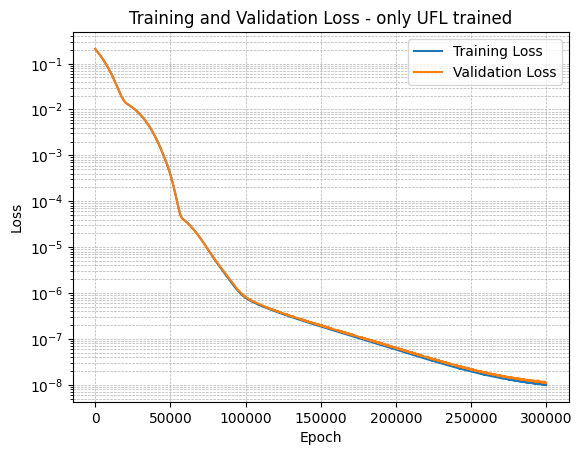

In [ ]:
# Code for training only UFL value
X_train_tensorUFL = torch.from_numpy(X_train.values.astype(np.float32))
UFL_train_tensor = torch.from_numpy(Su_train['UFL'].values.astype(np.float32)).view(-1,1)

X_test_tensorUFL = torch.from_numpy(X_test.values.astype(np.float32))
UFL_test_tensor = torch.from_numpy(Su_test['UFL'].values.astype(np.float32)).view(-1, 1)

X_val_tensorUFL = torch.from_numpy(X_val.values.astype(np.float32))
UFL_val_tensor = torch.from_numpy(Su_val['UFL'].values.astype(np.float32)).view(-1, 1)

optimizer = optim.Adam(UFLmodel.parameters(), lr=0.000001)
loss_fn = nn.MSELoss()

UFL_losses = []
UFL_val_losses = []

for epoch in tqdm(range(300000), desc = 'training process for UFL prediction'):
  #Training
  UFL_pred = UFLmodel(X_train_tensorUFL)
  loss = loss_fn(UFL_pred, UFL_train_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  UFL_losses.append(loss.item())

  # Validation
  UFLmodel.eval()  # Set the model to evaluation mode
  with torch.no_grad():  # No need to track the gradients
      UFL_val_pred = UFLmodel(X_val_tensorUFL)
      UFLval_loss = loss_fn(UFL_val_pred, UFL_val_tensor)
      UFL_val_losses.append(UFLval_loss.item())


# Plotting both training and validation losses
plt.figure()
plt.semilogy(UFL_losses, label='Training Loss')
plt.semilogy(UFL_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.title('Training and Validation Loss - only UFL trained')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()



training process for LFL and UFL prediction:   0%|          | 0/50000 [00:00<?, ?it/s]

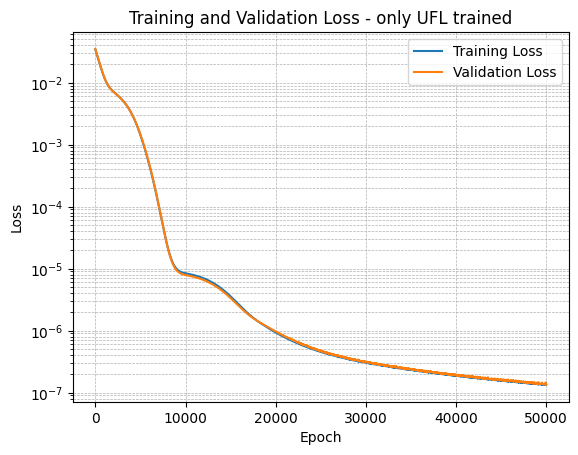

In [ ]:
# Code for training LFL and UFL values
FL_train = Su_train.drop(['Su_stoich'], axis=1)
FL_test = Su_test.drop(['Su_stoich'], axis=1)
FL_val = Su_val.drop(['Su_stoich'], axis=1)

X_train_tensorFL = torch.from_numpy(X_train.values.astype(np.float32))
FL_train_tensor = torch.from_numpy(FL_train.values.astype(np.float32)).view(-1,2)

X_test_tensorFL = torch.from_numpy(X_test.values.astype(np.float32))
FL_test_tensor = torch.from_numpy(FL_test.values.astype(np.float32)).view(-1, 2)

X_val_tensorFL = torch.from_numpy(X_val.values.astype(np.float32))
FL_val_tensor = torch.from_numpy(FL_val.values.astype(np.float32)).view(-1, 2)

optimizer = optim.Adam(FLmodel.parameters(), lr=0.00001)
loss_fn = nn.MSELoss()

FL_losses = []
FL_val_losses = []

for epoch in tqdm(range(50000), desc = 'training process for LFL and UFL prediction'):
  #Training
  FL_pred = FLmodel(X_train_tensorFL)
  loss = loss_fn(FL_pred, FL_train_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  FL_losses.append(loss.item())

  # Validation
  FLmodel.eval()  # Set the model to evaluation mode
  with torch.no_grad():  # No need to track the gradients
      FL_val_pred = FLmodel(X_val_tensorFL)
      FLval_loss = loss_fn(FL_val_pred, FL_val_tensor)
      FL_val_losses.append(FLval_loss.item())


# Plotting both training and validation losses
plt.figure()
plt.semilogy(FL_losses, label='Training Loss')
plt.semilogy(FL_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.title('Training and Validation Loss - only UFL trained')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


#### Flame Speed - 1

training process for Laminar Flame Speed prediction:   0%|          | 0/2000000 [00:00<?, ?it/s]

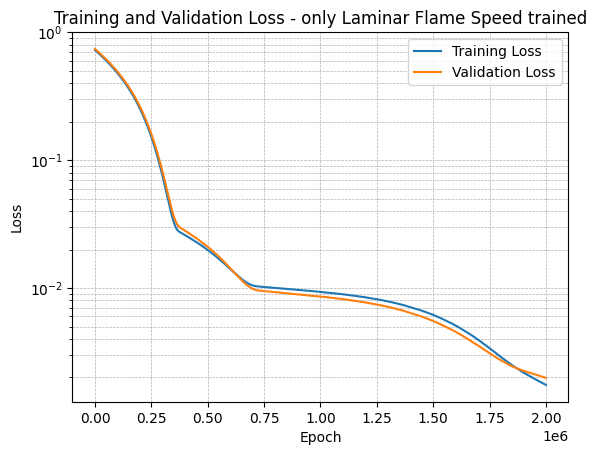

In [ ]:
# Code for training only Laminar Flame Speed value
X_train_tensorSu = torch.from_numpy(X_train.values.astype(np.float32))
Su_train_tensor = torch.from_numpy(Su_train['Su_stoich'].values.astype(np.float32)).view(-1,1)

X_test_tensorSu = torch.from_numpy(X_test.values.astype(np.float32))
Su_test_tensor = torch.from_numpy(Su_test['Su_stoich'].values.astype(np.float32)).view(-1, 1)

X_val_tensorSu = torch.from_numpy(X_val.values.astype(np.float32))
Su_val_tensor = torch.from_numpy(Su_val['Su_stoich'].values.astype(np.float32)).view(-1, 1)

optimizer = optim.Adam(Smodel.parameters(), lr=0.0000001)
loss_fn = nn.MSELoss()

Su_losses = []
Su_val_losses = []

for epoch in tqdm(range(2000000), desc = 'training process for Laminar Flame Speed prediction'):
  #Training
  Su_pred = Smodel(X_train_tensorSu)
  loss = loss_fn(Su_pred, Su_train_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  Su_losses.append(loss.item())

  # Validation
  Smodel.eval()  # Set the model to evaluation mode
  with torch.no_grad():  # No need to track the gradients
      Su_val_pred = Smodel(X_val_tensorSu)
      Suval_loss = loss_fn(Su_val_pred, Su_val_tensor)
      Su_val_losses.append(Suval_loss.item())


# Plotting both training and validation losses
plt.figure()
plt.semilogy(Su_losses, label='Training Loss')
plt.semilogy(Su_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.title('Training and Validation Loss - only Laminar Flame Speed trained')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()



#### Flame Speed - 2

*Testing the impact of normalization on learning rate*

In [16]:
# Code for training only Laminar Flame Speed value
X_train_tensorSu = torch.from_numpy(X_train.values.astype(np.float32))

# Normalize flame speed tensor values (i.e. divide by 3.0)
n_Su_train = (Su_train['Su_stoich'].values.astype(np.float32))
n_Su_train_tensor = torch.from_numpy(n_Su_train/3.0).view(-1,1)

X_test_tensorSu = torch.from_numpy(X_test.values.astype(np.float32))
n_Su_test = (Su_train['Su_stoich'].values.astype(np.float32))
n_Su_test_tensor = torch.from_numpy(n_Su_test/3.0).view(-1, 1)

X_val_tensorSu = torch.from_numpy(X_val.values.astype(np.float32))
n_Su_val = (Su_val['Su_stoich'].values.astype(np.float32))
n_Su_val_tensor = torch.from_numpy(n_Su_val/3.0).view(-1, 1)


In [21]:
Smodel2 = SNN()
Su_losses2 = []
Su_val_losses2 = []

optimizer2 = optim.Adam(Smodel2.parameters(), lr=0.00001)
loss_fn2 = nn.MSELoss()

In [26]:
for epoch in tqdm(range(80000), desc = 'training process for Laminar Flame Speed prediction'):
  #Training
  Su_pred = Smodel2(X_train_tensorSu)
  loss = loss_fn2(Su_pred, n_Su_train_tensor)
  optimizer2.zero_grad()
  loss.backward()
  optimizer2.step()

  Su_losses2.append(loss.item())

  # Validation
  Smodel2.eval()  # Set the model to evaluation mode
  with torch.no_grad():  # No need to track the gradients
      Su_val_pred = Smodel2(X_val_tensorSu)
      Suval_loss = loss_fn2(Su_val_pred, n_Su_val_tensor)
      Su_val_losses2.append(Suval_loss.item())

training process for Laminar Flame Speed prediction:   0%|          | 0/80000 [00:00<?, ?it/s]

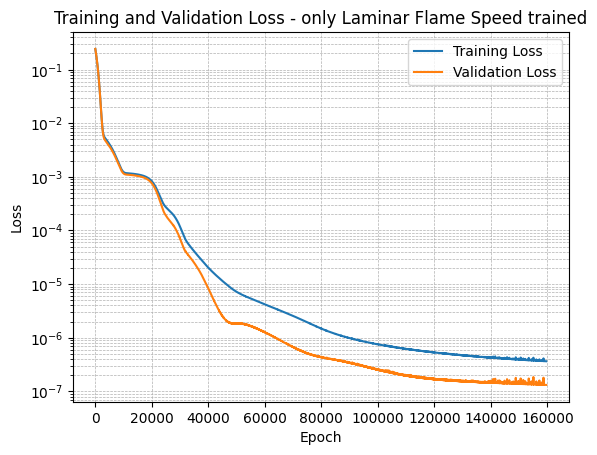

In [27]:
# Plotting both training and validation losses
plt.figure()
plt.semilogy(Su_losses2, label='Training Loss')
plt.semilogy(Su_val_losses2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.title('Training and Validation Loss - only Laminar Flame Speed trained')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

#### Flame Speed - 3

In [59]:
Smodel4 = SNN4()
Su_losses4 = []
Su_val_losses4 = []

optimizer4 = optim.Adam(Smodel4.parameters(), lr=0.0001)
loss_fn4 = nn.MSELoss()

In [60]:
for epoch in tqdm(range(40000), desc = 'training process for Laminar Flame Speed prediction'):
  #Training
  Su_pred = Smodel4(X_train_tensorSu)
  loss = loss_fn4(Su_pred, n_Su_train_tensor)
  optimizer4.zero_grad()
  loss.backward()
  optimizer4.step()

  Su_losses4.append(loss.item())

  # Validation
  Smodel4.eval()  # Set the model to evaluation mode
  with torch.no_grad():  # No need to track the gradients
      Su_val_pred = Smodel4(X_val_tensorSu)
      Suval_loss = loss_fn4(Su_val_pred, n_Su_val_tensor)
      Su_val_losses4.append(Suval_loss.item())

training process for Laminar Flame Speed prediction:   0%|          | 0/40000 [00:00<?, ?it/s]

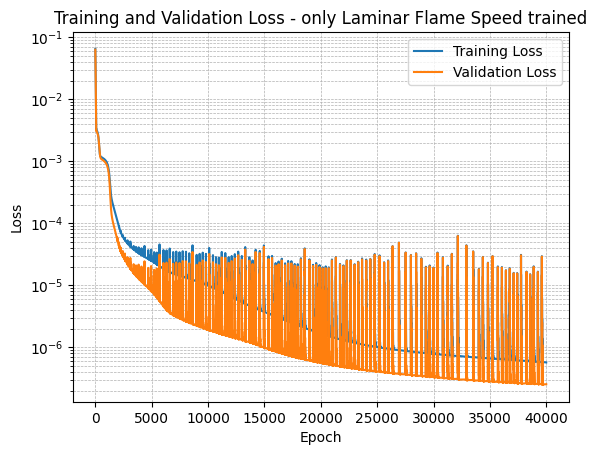

In [61]:
# Plotting both training and validation losses
plt.figure()
plt.semilogy(Su_losses4, label='Training Loss')
plt.semilogy(Su_val_losses4, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.title('Training and Validation Loss - only Laminar Flame Speed trained')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

### Model Testing and Validation

In [ ]:
#Testing the LFL trained model
with torch.no_grad():
    LFLtest_pred = LFLmodel(X_test_tensorLFL)

print("Predicted test LFL:", LFLtest_pred)
print("Target test LFL:", LFL_test_tensor)


Predicted test LFL: tensor([[0.0354],
        [0.0385],
        [0.0514],
        ...,
        [0.0361],
        [0.0406],
        [0.0295]])
Target test LFL: tensor([[0.0355],
        [0.0385],
        [0.0514],
        ...,
        [0.0359],
        [0.0406],
        [0.0294]])


In [ ]:
#Testing the UFL trained model
with torch.no_grad():
    UFLtest_pred = UFLmodel(X_test_tensorUFL)

print("Predicted test UFL:", UFLtest_pred)
print("Target test UFL:", UFL_test_tensor)


Predicted test UFL: tensor([[0.3531],
        [0.4209],
        [0.4504],
        ...,
        [0.5865],
        [0.2678],
        [0.3612]])
Target test UFL: tensor([[0.3530],
        [0.4207],
        [0.4504],
        ...,
        [0.5863],
        [0.2678],
        [0.3612]])


In [ ]:
#Testing the LFL and UFL trained model
with torch.no_grad():
    FLtest_pred = FLmodel(X_test_tensorFL)
print("Predicted test LFL and UFL:", FLtest_pred)
print("Target test LFL and UFL:", FL_test_tensor)


Predicted test LFL and UFL: tensor([[0.0355, 0.3528],
        [0.0386, 0.4211],
        [0.0514, 0.4506],
        ...,
        [0.0360, 0.5873],
        [0.0407, 0.2677],
        [0.0293, 0.3605]])
Target test LFL and UFL: tensor([[0.0355, 0.3530],
        [0.0385, 0.4207],
        [0.0514, 0.4504],
        ...,
        [0.0359, 0.5863],
        [0.0406, 0.2678],
        [0.0294, 0.3612]])


In [ ]:
#Testing the Laminar Flame Speed trained model
with torch.no_grad():
    Sutest_pred = Smodel(X_test_tensorSu)
print("Predicted test Laminar Flame Speed:", Sutest_pred)
print("Target test Laminar Flame Speed:", Su_test_tensor)


Predicted test Laminar Flame Speed: tensor([[0.5628],
        [0.6014],
        [0.5478],
        ...,
        [0.5678],
        [0.5118],
        [0.7729]])
Target test Laminar Flame Speed: tensor([[0.5363],
        [0.5731],
        [0.5365],
        ...,
        [0.5775],
        [0.5313],
        [0.7796]])


### Model Saving and Export

In [ ]:
# Save the trained LFL model
torch.save(LFLmodel, 'trained_LFL.pth')

#Save the trained UFL model
torch.save(UFLmodel, 'trained_UFL.pth')

#Save the trained Laminar Flame Speed model
torch.save(Smodel, 'trained_Su.pth')

## Model Refinement

# APPENDIX

*There are a few things that should be figured out at some point to make life easier from a coding and time perspective.*

1. **Training Checkpoints** ---> How do I implement check points in the training process in case I lose connection, or the notebook times out, or who know what. Not having to start training from scratch if someting goes wrong would be very helpful.

2. **Model Saving and Exporting**  ---> Once I've got a model that I like, how do I save it for export, sharing, or reuse later? Is it as simple as saving the weights? Are there other considerations?

3. **Local or Cloud**  ---> Is it better to run on Colab with more resources and time limits or locally on my GPU with no time limit?

## Testing the improve sample generation function

In [ ]:
# SET PROXY FUNCTION ARGUMENT VALUES
species = fuel_species
num = 10000
rand = True
####################################

# Function code
###############

# Define useful stuff
species_count = len(species)
mixtures = [] # Intialize empty array to hold the mixtures as they are generated

# Determine if randomization should be seeded
if not rand:
# Seed the random number generation so that I will consistently get the same random set for testing
  np.random.seed(1234)
  random.seed(1234)

# Testing iteration loop
for i in tqdm(range(10)):
  sub_num = random.randint(2, species_count)   # Randomly pick what number of constituents will be used
  # print(sub_num)                               # DIAGNOSTIC PRINTING

  sub_list = random.sample(species, sub_num)   # Randomly choose the particular species that will be used for this mixture
  # print(sub_list)                              # DIAGNOSTIC PRINTING

  mix_dict = {spec: 0 for spec in species}     # Initialize an empty dict with keys for all items in "species"
  # print(mix_dict)                              # DIAGNOSTIC PRINTING

  # Generate values for chosen species and normalize
  sub_values = [random.uniform(0, 1) for _ in range(len(sub_list))] #Generate values between 0 and 1 for the chosen species
  total_fraction = sum(sub_values)    # Find sum of fraction values
  sub_values = [frac/total_fraction for frac in sub_values]   # Normalize the sub_values list so that all items sum to one
  sub_round = [round(x, 4) for x in sub_values]               # Round the values to 4 decimal places

  # Iterate through and assign values for chosen species to overall mixture dict
  for i, spec in enumerate(sub_list):
     mix_dict[spec] = sub_round[i]

  # print(mix_dict)   # DIAGNOSTIC PRINTING

  mixtures.append(mix_dict)

###################################
test_df = pd.DataFrame(mixtures)

test_df

  # print('\n')   # DIAGNOSTIC PRINTING

# DIAGNOSTICS - NOT NEEDED
# for i in mixtures:

#   total = sum(i.values())
#   print(total)


# # Generate random fractions for each gas species
#       fractions = [random.uniform(0, 1) for _ in range(len(fuel_species))]

#       # Normalize the fractions so they sum up to 1
#       total_fraction = sum(fractions)
#       fractions = [frac / total_fraction for frac in fractions]


  0%|          | 0/10 [00:00<?, ?it/s]

,CO,H2,CH4,C2H6,C3H8
0,0.2981,0.2058,0.3660,0.0944,0.0357
1,0.0000,0.0000,0.5735,0.4265,0.0000
2,0.0000,0.2443,0.1686,0.2447,0.3424
3,0.0000,0.0000,0.0000,0.6969,0.3031
4,0.3570,0.1569,0.0000,0.0938,0.3923
5,0.5550,0.0000,0.4450,0.0000,0.0000
6,0.1368,0.2569,0.3587,0.1226,0.1249
7,0.0000,0.3236,0.3585,0.0000,0.3179
8,0.0000,0.1590,0.2898,0.4202,0.1310
9,0.4716,0.0298,0.0000,0.4986,0.0000


## Testing Unique Identifier String

In [ ]:
unique_string = str(uuid.uuid4())

unique_string

'bc47c2ae-555b-4e1c-aacc-180b5a12c6ec'

In [ ]:
current = datetime.now()
current.strftime('%m%d_%H%M%S')

'1120_140347'

# REFERENCES

## Cantera (GRI3) Master Species List

*Cantera can use whatever species you like in calculations, provided thermodynamic data is available for it. This is typicall provided via "mechanism" files. The one that is used by default is the GRI-Mech3.0 mechanism. Other mechanisms are avaialbe from reputable sources online. for the purposes of this project, I see no reason to add that complication.*

*Below is a list of the included species:*

In [ ]:
list_gas = ct.Solution('gri30.yaml')          # Create a Cantera object
list_species = list_gas.species_names         # Get list with all included species labels
master_species_array = np.array(list_species) # Convert to a numpy array
master_species_array

array(['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'C', 'CH', 'CH2',
       'CH2(S)', 'CH3', 'CH4', 'CO', 'CO2', 'HCO', 'CH2O', 'CH2OH',
       'CH3O', 'CH3OH', 'C2H', 'C2H2', 'C2H3', 'C2H4', 'C2H5', 'C2H6',
       'HCCO', 'CH2CO', 'HCCOH', 'N', 'NH', 'NH2', 'NH3', 'NNH', 'NO',
       'NO2', 'N2O', 'HNO', 'CN', 'HCN', 'H2CN', 'HCNN', 'HCNO', 'HOCN',
       'HNCO', 'NCO', 'N2', 'AR', 'C3H7', 'C3H8', 'CH2CHO', 'CH3CHO'],
      dtype='<U6')

In [ ]:
# List of species I might care about for this project

# This is is the list of all species that I consider potentially
# relevant in GRI-Mech3.0 such as common flammable and hydrocarbon
# fuels.
relevant_species = {'Hydrogen': 'H2',
                    'Oxygen': 'O2',
                    'Nitrogen': 'N2',
                    'Argon': 'AR',
                    'Water': 'H20',
                    'Methane': 'CH4',
                    'Acetylene': 'C2H2',
                    'Ethylene': 'C2H4',
                    'Ethane': 'C2H6',
                    'Propane': 'C3H8',
                    'Ammonia': 'NH3'}